Heart diseases prediction

Задача: предсказание проблем с сердцем по жизненым показателям.

# Загрузка данных

Импорт библиотек

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBClassifier

Загрузим данные.

In [2]:
#загрузка данных
try:
    df = pd.read_csv('train.csv', index_col = 0)
    df_test = pd.read_csv('test.csv', index_col = 0)
except:
    print('File ead error!')

Изучим основную информацию о таблице.

In [3]:
#вывод основной информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


У нас 70000 строкб 11 столбцов. Пропусков нет. 

Изучим первые 5 строк.

In [4]:
#вывод на экран первых пяти строк таблицы
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Выведем на экран основные статистики

In [5]:
#вывод на экран основных статистик
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,70000.0,19468.865814,2467.251667,10798.0,17664.0,19703.0,21327.0,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.0,1.0,2.0,2.0
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0
weight,70000.0,74.205690,14.395757,10.0,65.0,72.0,82.0,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.0,120.0,140.0,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.0,80.0,90.0,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.0,1.0,2.0,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.0,1.0,1.0,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.0,0.0,0.0,1.0
alco,70000.0,0.053771,0.225568,0.0,0.0,0.0,0.0,1.0


age - вероятно задан в днях,<br>
gender - есть два пола 1 и 2,<br>
height - присутсвуют не нормальние значения роста в 55 см и 250,<br>
weight - присутствуют странные значения в 10 кг,<br>
ap_hi - есть отрицательные и запредельно большие значения,<br>
ap_lo - есть отрицательные и запредельно большие значения,<br> 
cardio - целевой столбец

Проверим кореляцию между столбцами.

In [6]:
#вывод таблицы корреляций
df.corr()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159
gender,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486
alco,-0.029723,0.170966,0.094419,0.067113,0.001408,0.010601,0.035760,0.011246,0.340094,1.000000,0.025476,-0.007330


Сильной кореляции между столбцами нет.

## Вывод

В данных нет пропусков. Тип столбца weight не оптимальный, лучше изменить на int.<br>
age - вероятно задан в днях,<br>
gender - есть два пола 1 и 2,<br>
height - присутсвуют не нормальние значения роста в 55 см и 250,<br>
weight - присутствуют странные значения в 10 кг,<br>
ap_hi - есть отрицательные и запредельно большие значения,<br>
ap_lo - есть отрицательные и запредельно большие значения,<br> 
cardio - целевой столбец

# Подготовка данных

Изменим тип столбца weight на int и уберем отрицательные значения.

In [7]:
#смена типа столбца weight на int
df.weight = abs(df.weight.astype('int'))
df_test.weight = abs(df_test.weight.astype('int'))
#уберем отрицательные значения в столбце height
df.height = abs(df.height)
df_test.height = abs(df_test.height)
#уберем отрицательные значения в столбце ap_hi
df.ap_hi = abs(df.ap_hi)
df_test.ap_hi = abs(df_test.ap_hi)
#уберем отрицательные значения в столбце ap_lo
df.ap_lo = abs(df.ap_lo)
df_test.ap_lo = abs(df_test.ap_lo)

## Возраст (age)

Начнем с изучения столбца возраст. Построим гистограмму, "ящик с усами".

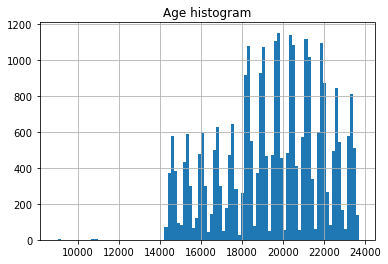

In [8]:
plt.hist(df_test.age, bins = 100, label = 'Age')
plt.grid(True)
plt.title('Age histogram')
plt.show()

In [9]:
df['age'].sort_values().head()

id
31922    10798
43842    10859
8850     10878
79749    10964
45362    14275
Name: age, dtype: int64

На гистограмме есть несколько значений - выбросов. Исправим их.

In [10]:
df.loc[df['age']< 14275, 'age'] = 14275
df_test.loc[df_test['age']< 14275, 'age'] = 14275

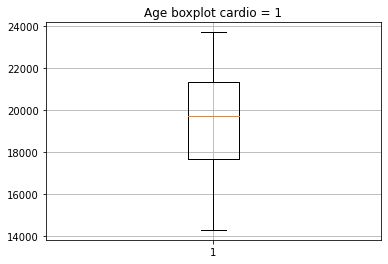

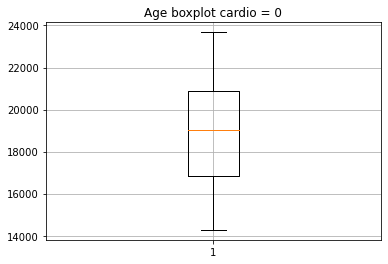

In [11]:
plt.boxplot(df_test.age)
plt.grid(True)
plt.title('Age boxplot cardio = 1')
plt.show()
plt.boxplot(df[df['cardio']==0].age)
plt.grid(True)
plt.title('Age boxplot cardio = 0')
plt.show()

Выбросы исправлены. По графику Boxplot можно обнаружить, что в среднем пациенты имеющие проблемы с сердцем старше чем те, кто не имеет. Гистограмма осталась мультимодальной, однако идей причины такого распределения у меня нет.

У нас есть странные значения столбцов. Как их исправить не понятно, но пометим их для дальнейшей работы.

# Рост и вес (height, weight)

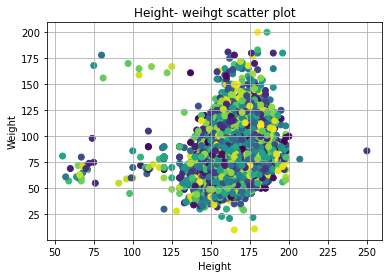

In [12]:
colors = np.random.uniform(15, 80, len(df))
plt.scatter(df.height, df.weight, c = colors)
plt.grid(True)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height- weihgt scatter plot')
plt.show()

Между ростом и весом в жизни существует достаточно сильная линейная зависимость. Однако по нашим данным очень много выбросов и странный перекос.

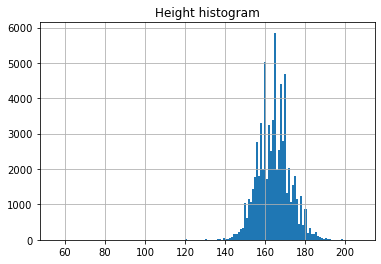

In [13]:
plt.hist(df[df['height'] < 250].height, bins = 150)
plt.grid(True)
plt.title('Height histogram')
plt.show()

На Гистограмме присутствуют странные пики. Их надо проверить

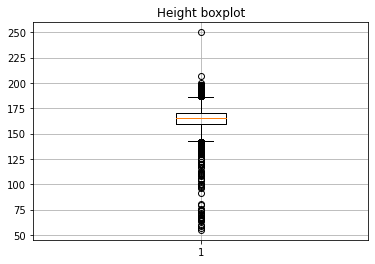

In [14]:
plt.boxplot(df.height)
plt.grid(True)
plt.title('Height boxplot')
plt.show()

Рассмотрим значения Height больше 200 и меньше 148, но предварительно проверим, вдруг вес и рос при ввроде просто перепутали. Тоесть значения роста меньше чем веса.

In [15]:
df[df['height'] < df['weight']]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
552,16718,2,165,169,120,80,1,1,0,0,1,0
618,16765,1,186,200,130,70,1,1,0,0,0,0
3470,23646,2,159,165,130,70,1,1,0,0,0,0
6716,17218,2,176,180,140,90,1,1,0,0,1,1
8757,20990,1,122,161,120,80,1,1,0,0,1,1
10843,14661,2,70,72,120,8,1,1,0,0,1,0
11662,17646,2,97,170,160,100,1,1,1,0,1,1
17757,22077,1,137,161,150,100,2,1,0,0,0,1
18218,19594,1,75,168,120,80,1,1,1,0,1,1


Ситуация сложная но решаемая. Вариант 1 - вес и рост мешьше чем 100, более вероятно что в росте забыли 1, а вес правильный. Вариант 2. Рост менее 147 и вес больше 100, вероятно перепутали местами рост и вес. Вариант 3. Если и рост больше 147 и вес больше 100 - вероятно в весе присутствует лишняя цифра 1. Исправим согласно предположениям.

In [16]:
def height_weight(row):
    if (row['height'] < row['weight']) & (row['height']< 100) & (row['weight'] < 100):
        row['height'] = row['height'] + 100
    elif (row['height'] < row['weight']) & (row['height']< 147) & (row['weight'] > 99):
        row['height'], row['weight'] = row['weight'], row['height']
    elif (row['height'] < row['weight']) & (row['height'] > 147) & (row['weight'] > 99):
        row['weight'] = row['weight'] - 100
    return row
        

In [17]:
df = df.apply(height_weight, axis = 1)
df_test = df_test.apply(height_weight, axis = 1)

In [18]:
df[df['height'] < df['weight']]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,


In [19]:
df[df['height'] > 200]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
9223,21220,1,250,86,140,100,3,1,0,0,1,1
30894,19054,2,207,78,100,70,1,1,0,1,1,0


В дальнейшем эти выбросы заменим на средние по весу, однако столбец вес тоже может содержать проблемы, поэтому пока заменим на значение 250

In [20]:
df.loc[df['height'] > 200, 'height'] = 250
df_test.loc[df_test['height'] > 200, 'height'] = 250

Рассмотрим значения менее 145 в 2 этапа, на первом - рассмотрим менее 100, затем остальные.

In [21]:
df[df['height'] < 100]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
309,21800,2,76,55,120,80,1,1,0,0,1,0
18928,22456,2,71,68,120,80,3,1,0,0,1,0
20459,22005,1,67,57,120,90,1,1,0,0,1,1
21686,15812,1,70,68,120,80,1,1,0,0,0,0
24690,17530,1,98,45,12,80,1,1,0,0,1,0
32207,14538,1,68,65,100,60,1,1,0,0,0,0
39462,20978,1,64,61,130,70,1,1,0,0,1,0
41075,19747,1,91,55,140,90,1,1,0,0,1,1
63545,19120,1,65,60,120,80,1,1,0,0,1,0


In [22]:
df.loc[df['height'] < 100, 'height'] = df['height'] + 100
df_test.loc[df_test['height'] < 100, 'height'] = df_test['height'] + 100

Видно что в начале просто забыли дописать 1. Добавим к росту 100, что бы выровнять ситуацию.

In [23]:
df_test[df_test['height'] < 148]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
id,,,,,,,,,,,
445,23550,1,147,61,140,100,1,1,0,0,0
644,18994,1,110,90,110,90,2,2,0,0,1
804,23161,1,145,42,140,80,1,1,0,0,0
1701,16630,1,145,57,120,80,1,1,0,0,1
2088,16502,1,147,68,110,90,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
99335,19740,1,120,80,120,80,1,1,0,0,1
99738,23192,1,146,58,110,70,2,1,0,0,1
99873,18380,1,143,76,120,80,1,1,0,0,1


Замечено, что есть строки где высота и вес полностью совпадают с давлением верхним и нижним. Та не бывает. Заменим все такие занfчения роста и веса на 250 при условии что рост менее 147. В дальнейшем проверим такие совпадения при более высоком росте.

In [24]:
df.loc[(df['height'] < 148) & (df['height'] == df['ap_hi']) & (df['weight'] == df['ap_lo']), 'height'] = 250
df_test.loc[(df_test['height'] < 148) & (df_test['height'] == df_test['ap_hi']) & (df_test['weight'] == df_test['ap_lo']), 'height'] = 250

Оставшиеся значения тоже заменим на 250.

In [25]:
df.loc[df['height'] < 148, 'height'] = 250
df_test.loc[df_test['height'] < 148, 'height'] = 250

Теперь рассмотрим ситуацию, когда рост и вес равны давлению, при условии роста более 147.

In [26]:
df[(df['height'] == df['ap_hi']) & (df['weight'] == df['ap_lo'])]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
1586,23351,1,150,90,150,90,3,2,0,0,1,1
2122,16534,1,164,73,164,73,1,1,0,0,1,1
5378,23434,1,150,61,150,61,1,3,0,0,1,1
12651,18829,2,160,90,160,90,2,2,0,0,1,1
15864,21056,2,162,82,162,82,1,1,0,0,0,1
17058,20640,2,167,71,167,71,1,1,0,0,1,1
17511,14906,1,158,92,158,92,3,3,0,0,1,0
22951,22062,1,157,80,157,80,1,1,0,0,1,1
24148,20296,1,160,58,160,58,1,1,0,0,1,1


В случае если значение роста делится без остатка на 10, то более вероятно, что в графу роста и веса вбили давление, а если не делится без остатка на 10, то более вероятно, что вес и рост вбили в графу давление

In [27]:
df.loc[(df['height'] == df['ap_hi']) & (df['weight'] == df['ap_lo']) & (df['height']%10 == 0), 'height'] = 250
df_test.loc[(df_test['height'] == df_test['ap_hi']) & (df_test['weight'] == df_test['ap_lo']) & (df_test['height']%10 == 0), 'height'] = 250

In [28]:
def height_ap(row):
    if (row['height'] == row['ap_hi']) & (row['weight'] == row['ap_lo']) & (row['height']%10 != 0):
        row['ap_lo'] = -1
        row['ap_hi'] = -1
    return row

In [29]:
df = df.apply(height_ap, axis = 1)
df_test = df_test.apply(height_ap, axis = 1)

Теперь осмотрим вес и затем заполним помеченные значения

Начнем со значений, которые у нас остались еще с исследования роста. А именно  - когда рост и вес равны давлению. Рассмотрим эту ситуацию. и все значения веса заменим на "-1"

In [30]:
df.loc[(df['height'] == 250) & (df['ap_lo'] == df['weight']), 'weight'] = -1
df_test.loc[(df_test['height'] == 250) & (df_test['ap_lo'] == df_test['weight']), 'weight'] = -1

рассмотрим ситуацию, когда вес равен росту.

In [31]:
df[(df['weight'] == df['height'])]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
3438,19171,2,177,177,130,90,1,1,0,0,1,1
4672,17545,1,155,155,160,1000,1,1,0,0,1,1
4825,14585,1,159,159,100,80,1,1,0,0,1,0
26630,18273,1,168,168,110,70,1,1,0,0,1,1
27962,23193,1,162,162,150,90,1,1,0,0,1,1
59768,20464,1,164,164,140,90,3,3,0,0,1,1
83932,21924,1,170,170,120,80,1,1,0,0,1,1
86506,18975,2,180,180,140,100,3,1,0,0,1,1
91284,21115,1,164,164,120,80,1,1,0,0,1,0


Такая ситаация крайне маловероятно, поэтому изменим значения веса на -1

In [32]:
df.loc[(df['weight'] == df['height']), 'weight'] = -1
df_test.loc[(df_test['weight'] == df_test['height']), 'weight'] = -1

Теперь можно поправить занчения роста, которые мы пометили, как не верные. Заменим значения на 160 + randint(10). Так мы попадем с редний диапазон роста человека.

In [33]:
np.random.seed(12345) 
df.loc[df['height']==250, 'height'] = 160 + np.random.randint(10)
df_test.loc[df_test['height']==250, 'height'] = 160 + np.random.randint(10)

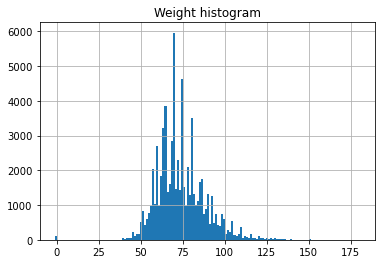

In [34]:
plt.hist(df.weight, bins = 150)
plt.grid(True)
plt.title('Weight histogram')
plt.show()

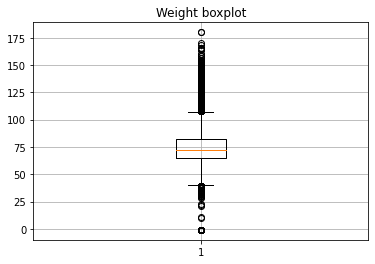

In [35]:
plt.boxplot(df.weight)
plt.grid(True)
plt.title('Weight boxplot')
plt.show()

Рассмотрим вес больше 130, потому что до 130 вес не такая уж и редкость.

In [36]:
df[df['weight'] > 130]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
474,21078,1,157,142,120,80,1,1,0,0,1,1
1673,19822,1,171,139,140,90,1,1,0,0,1,1
1785,19022,2,175,150,180,120,2,1,0,1,1,1
1794,21042,1,170,138,140,90,1,1,0,0,1,1
1965,22644,1,166,131,120,80,3,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95549,23260,2,170,134,140,100,3,3,0,0,1,0
95821,16222,2,178,146,140,1100,1,1,1,0,1,1
95877,19770,1,160,131,120,80,3,3,0,0,1,1


Значения не показывают каких то особенностей и вполне могут быть у людей. Рассмотрим значения менее 30. Такие значения уже угрожают жизни и более вероятно, что в них ошибка, изменим их на -1.

In [37]:
df.loc[(df['weight'] < 30) & (df['weight'] > -1), 'weight'] = -1
df_test.loc[(df_test['weight'] < 30) & (df_test['weight'] > -1), 'weight'] = -1

Теперь значения -1 заменим на медиану по соответствующему росту

In [38]:
pd.isna(df_test.weight).value_counts()

False    30000
Name: weight, dtype: int64

In [39]:
df_test.loc[df_test['weight']==-1].count()

age            44
gender         44
height         44
weight         44
ap_hi          44
ap_lo          44
cholesterol    44
gluc           44
smoke          44
alco           44
active         44
dtype: int64

In [40]:
df.loc[df['weight']==-1, 'weight'] = df.groupby('cholesterol').weight.transform('median')
df_test.loc[df_test['weight']==-1, 'weight'] = df_test.groupby('cholesterol').weight.transform('median')

In [41]:
df.weight = df.weight.astype(int)
df.height = df.height.astype(int)
df_test.height = df_test.height.astype(int)
df_test.weight = df_test.weight.astype(int)

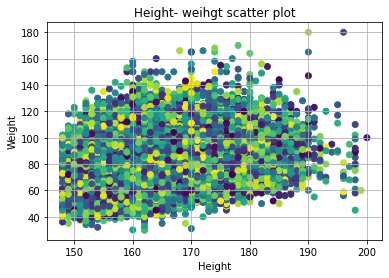

In [42]:
colors = np.random.uniform(15, 80, len(df))
plt.scatter(df.height, df.weight, c = colors)
plt.grid(True)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height- weihgt scatter plot')
plt.show()

Диаграмма уже больше похожа на правду, хотя все еще и обладает странностями. Оставим ее так и перейдем к другим признакам.

# Давление (ap_hi, ap_lo)

Построим Scatter Plot давления

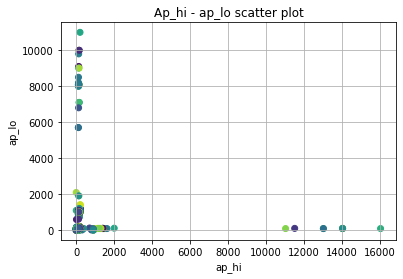

In [43]:
colors = np.random.uniform(15, 80, len(df))
plt.scatter(df.ap_hi, df.ap_lo, c = colors)
plt.grid(True)
plt.xlabel('ap_hi')
plt.ylabel('ap_lo')
plt.title('Ap_hi - ap_lo scatter plot')
plt.show()

У значений ap_hi и ap_lo очень сильные выбросы. Необходимо сначала их подчистить, и потом строить графики.

Вначале исправим все значения более 9999. просто поделим их без остатка на 100

In [44]:
df.loc[df['ap_hi'] > 9999, 'ap_hi'] = df['ap_hi']//100
df_test.loc[df_test['ap_hi'] > 9999, 'ap_hi'] = df_test['ap_hi']//100

In [45]:
df.loc[df['ap_lo'] > 4000, 'ap_lo'] =  df['ap_lo']//100
df_test.loc[df_test['ap_lo'] > 4000, 'ap_lo'] =  df_test['ap_lo']//100

Теперь исправим значения ap_hi более 999, разделим их без остатка на 10.

In [46]:
df.loc[df['ap_hi'] > 999, 'ap_hi'] = df['ap_hi']//10
df_test.loc[df_test['ap_hi'] > 999, 'ap_hi'] = df_test['ap_hi']//10

Рассмотрим значения ap_lo более 2000.

In [47]:
df.loc[df['ap_lo'] > 2000]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
12494,16905,2,163,63,1,2088,1,1,1,0,1,0


При рассмотрении обнаружилась ошибка ввода, когда в ap_hi ввели только певую цифру, а остальные показатели давления ввели в ap_lo. Исправим.

In [48]:
df.loc[df['ap_hi'] == 1]


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
12494,16905,2,163,63,1,2088,1,1,1,0,1,0
60477,18716,1,171,80,1,1088,1,1,0,0,1,1


In [49]:
def one_change(row):
    item = 0
    if row['ap_hi'] == 1:
        item = str(int(row['ap_hi'])) + str(int(row['ap_lo']))

        row['ap_hi'] = int(item[:3])
        if (item[3:]) == '':
              row['ap_lo'] = 90
        else:
              row['ap_lo'] = int(item[3:])
    return row

In [50]:
df = df.apply(one_change, axis = 1)
df_test = df_test.apply(one_change, axis = 1)

In [51]:
df.loc[df['ap_lo'] > 1400, 'ap_lo'] = (df['ap_lo']%1000)//10
df_test.loc[df_test['ap_lo'] > 1400, 'ap_lo'] = (df_test['ap_lo']%1000)//10

In [52]:
df.loc[df['ap_lo'] > 200, 'ap_lo'] = df['ap_lo']//10
df_test.loc[df_test['ap_lo'] > 200, 'ap_lo'] = df_test['ap_lo']//10

In [53]:
def ap_hi_cor(row):
    if row['ap_hi']>240:
        if row['ap_lo'] == 0:
            row['ap_lo'] = (row['ap_hi']%10)*10
            row['ap_hi'] = row['ap_hi']//10
        elif row['ap_hi']%10 == 1:
            row['ap_hi'] = row['ap_hi']//10 + 100
        else:
            row['ap_hi'] = row['ap_hi']//10
    return row

In [54]:
df = df.apply(ap_hi_cor, axis =1)
df_test = df_test.apply(ap_hi_cor, axis =1)

Теперь можно построить графики.

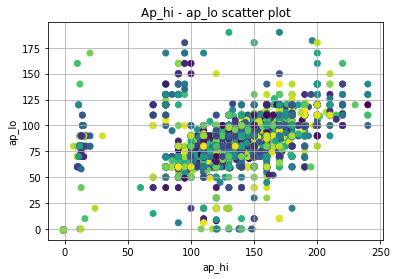

In [55]:
colors = np.random.uniform(15, 80, len(df))
plt.scatter(df.ap_hi, df.ap_lo, c = colors)
plt.grid(True)
plt.xlabel('ap_hi')
plt.ylabel('ap_lo')
plt.title('Ap_hi - ap_lo scatter plot')
plt.show()

Видно что в обоих столбцах есть значения меньше 50, что не естественно для человека. Исправим.

In [56]:
df.loc[(df['ap_hi']>-1) & (df['ap_hi'] < 20), 'ap_hi'] = df['ap_hi']*10
df_test.loc[(df_test['ap_hi']>-1) & (df_test['ap_hi'] < 20), 'ap_hi'] = df_test['ap_hi']*10

In [57]:
df.loc[(df['ap_hi']>-1) & (df['ap_hi'] < 50), 'ap_hi'] = df['ap_hi'] + 100
df_test.loc[(df_test['ap_hi']>-1) & (df_test['ap_hi'] < 50), 'ap_hi'] = df_test['ap_hi'] + 100

In [58]:
df.loc[(df['ap_lo']>-1) & (df['ap_lo'] < 10), 'ap_lo'] = df['ap_lo']*10
df_test.loc[(df_test['ap_lo']>-1) & (df_test['ap_lo'] < 10), 'ap_lo'] = df_test['ap_lo']*10

In [59]:
df.loc[(df['ap_lo']>-1) & (df['ap_lo'] < 20), 'ap_lo'] = df['ap_lo']*10
df_test.loc[(df_test['ap_lo']>-1) & (df_test['ap_lo'] < 20), 'ap_lo'] = df_test['ap_lo']*10

In [60]:
df.loc[(df['ap_lo']>-1) & (df['ap_lo'] < 41), 'ap_lo'] = -1
df_test.loc[(df_test['ap_lo']>-1) & (df_test['ap_lo'] < 41), 'ap_lo'] = -1

In [61]:
df.loc[(df['ap_lo']>-1) & (df['ap_lo'] < 50) & (df['ap_hi'] > 99), 'ap_lo'] = -1
df_test.loc[(df_test['ap_lo']>-1) & (df_test['ap_lo'] < 50) & (df_test['ap_hi'] > 99), 'ap_lo'] = -1

Прежде чем продолжить чистку посмотрим сколько у нас строк, где верхнее давление выше чем нижнее

In [62]:
df[df['ap_hi'] < df['ap_lo']]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
681,19099,1,156,65,120,150,2,1,0,0,1,0
913,20457,2,169,68,70,110,1,1,0,0,1,0
3356,23361,1,154,102,90,150,1,1,0,0,0,1
4214,21957,2,182,90,80,140,3,3,0,0,1,1
4880,19992,2,180,80,80,125,3,3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
94673,22551,1,169,88,100,160,3,3,0,0,0,1
95164,19498,2,160,81,80,120,3,3,1,1,1,1
96271,23424,1,153,74,80,130,1,1,0,0,1,1


Сразу поменяем местами значения.

In [63]:
def ap_change_place(row):
    if (row['ap_hi'] < row['ap_lo']):
        row['ap_hi'] , row['ap_lo'] = row['ap_lo'], row['ap_hi']
    return row

In [64]:
df = df.apply(ap_change_place, axis = 1)
df_test = df_test.apply(ap_change_place, axis = 1)

Теперь рассмотрим угрожающие жизни состояния. ap_hi > 180 или ap_lo > 160

In [65]:
df[df['ap_hi'] > 180]['cardio'].value_counts()

1    284
0     48
Name: cardio, dtype: int64

In [66]:
df[df['ap_lo'] > 160]['cardio'].value_counts()

1    4
Name: cardio, dtype: int64

В целом таких значений не много и они в среднем действительно сигнализируют о проблемах с сердцем. Оставим как есть. Заметим отмеченные значения. Начнем с ар_lo. потом ap_hi. Заменять будем медианной по группе с аналогичным значением.

In [67]:
df.loc[df['ap_lo']==-1, 'ap_lo'] = df.groupby('ap_hi').weight.transform('median')
df_test.loc[df_test['ap_lo']==-1, 'ap_lo'] = df_test.groupby('ap_hi').weight.transform('median')

In [68]:
df.ap_lo = df.ap_lo.astype(int)
df_test.ap_lo = df_test.ap_lo.astype(int)

In [69]:
df.loc[df['ap_hi']==-1, 'ap_hi'] = df.groupby('ap_lo').weight.transform('median')
df_test.loc[df_test['ap_hi']==-1, 'ap_hi'] = df_test.groupby('ap_lo').weight.transform('median')

In [70]:
df.ap_hi = df.ap_hi.astype(int)
df_test.ap_hi = df_test.ap_hi.astype(int)

Рассмотрим ситуацию, когда разница между верхним и нижним давлением менее 10 и равна 10

In [71]:
df[(df['ap_hi'] - df['ap_lo']) < 11]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
288,18169,2,172,62,80,70,1,1,0,0,1,0
2122,16534,1,164,73,72,73,1,1,0,0,1,1
3373,19752,1,162,58,110,100,2,1,0,0,1,0
4926,18041,2,175,85,100,90,1,1,0,1,1,0
4957,14800,1,167,67,100,90,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
96207,23514,1,155,60,72,73,1,1,0,0,0,1
96340,17610,1,151,70,100,90,2,1,0,0,1,0
96865,16791,1,157,74,100,90,2,1,0,0,1,1


In [72]:
df.loc[(df['ap_hi'] - df['ap_lo']) < 10, 'ap_hi'] = df['ap_hi'] + 30
df_test.loc[(df_test['ap_hi'] - df_test['ap_lo']) < 10, 'ap_hi'] = df_test['ap_hi'] + 30

In [73]:
df.loc[(df['ap_hi'] - df['ap_lo']) == 10, 'ap_hi'] = df['ap_hi'] + 20
df_test.loc[(df_test['ap_hi'] - df_test['ap_lo']) == 10, 'ap_hi'] = df_test['ap_hi'] + 20

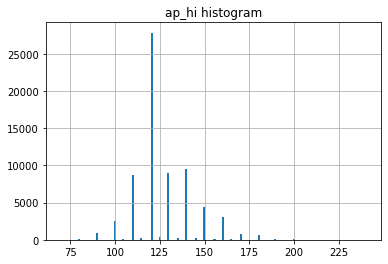

In [74]:
plt.hist(df.ap_hi, bins = 150)
plt.grid(True)
plt.title('ap_hi histogram')
plt.show()

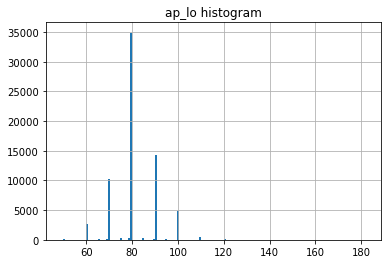

In [75]:
plt.hist(df.ap_lo, bins = 150)
plt.grid(True)
plt.title('ap_lo histogram')
plt.show()

In [76]:
df.loc[(df['ap_hi'] - df['ap_lo']) > 90, 'ap_lo'] = df['ap_lo'] + 50
df.loc[(df['ap_hi'] - df['ap_lo']) > 80, 'ap_lo'] = df['ap_lo'] + 40
df.loc[(df['ap_hi'] - df['ap_lo']) > 70, 'ap_lo'] = df['ap_lo'] + 30

df_test.loc[(df_test['ap_hi'] - df_test['ap_lo']) > 90, 'ap_lo'] = df_test['ap_lo'] + 50
df_test.loc[(df_test['ap_hi'] - df_test['ap_lo']) > 80, 'ap_lo'] = df_test['ap_lo'] + 40
df_test.loc[(df_test['ap_hi'] - df_test['ap_lo']) > 70, 'ap_lo'] = df_test['ap_lo'] + 30

# Добавляем новые признаки

Добавми столбец BMI

In [77]:
df['bmi'] = df['weight']/((df['height']/100)**2)
df_test['bmi'] = df_test['weight']/((df_test['height']/100)**2)

In [78]:
df['ap_dif'] = df['ap_hi'] - df['ap_lo']
df_test['ap_dif'] = df_test['ap_hi'] - df_test['ap_lo']

Проверим корреляцию после подготовки признаков.

In [79]:
#вывод матрицы корреляции
df.corr()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,ap_dif
age,1.000000,-0.022831,-0.081945,0.054805,0.207107,0.156256,0.154415,0.098693,-0.047668,-0.029748,-0.009891,0.238133,0.099311,0.173797
gender,-0.022831,1.000000,0.526347,0.157367,0.062607,0.061542,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109,-0.104334,0.035237
height,-0.081945,0.526347,1.000000,0.304961,0.020285,0.026346,-0.054130,-0.021529,0.197259,0.098504,-0.009418,-0.010679,-0.183116,0.003671
weight,0.054805,0.157367,0.304961,1.000000,0.274904,0.248396,0.143198,0.108300,0.068646,0.067442,-0.017618,0.183169,0.876304,0.181120
ap_hi,0.207107,0.062607,0.020285,0.274904,1.000000,0.833354,0.197023,0.094629,0.027958,0.036692,0.000790,0.432071,0.273044,0.743769
ap_lo,0.156256,0.061542,0.026346,0.248396,0.833354,1.000000,0.159874,0.076352,0.024915,0.037016,-0.002500,0.343234,0.242571,0.250352
cholesterol,0.154415,-0.035821,-0.054130,0.143198,0.197023,0.159874,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147,0.173943,0.151759
gluc,0.098693,-0.020491,-0.021529,0.108300,0.094629,0.076352,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307,0.121830,0.073414
smoke,-0.047668,0.338135,0.197259,0.068646,0.027958,0.024915,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486,-0.029022,0.018840
alco,-0.029748,0.170966,0.098504,0.067442,0.036692,0.037016,0.035760,0.011246,0.340094,1.000000,0.025476,-0.007330,0.019171,0.019504


Разобьем тренировочную выборку на признаки и целевой столбец.

In [80]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,70000.0,19469.060114,2466.708638,14275.000000,17664.000000,19703.000000,21327.000000,23713.00000
gender,70000.0,1.349571,0.476838,1.000000,1.000000,1.000000,2.000000,2.00000
height,70000.0,164.644329,7.544884,148.000000,159.000000,165.000000,170.000000,200.00000
weight,70000.0,74.157071,14.227835,30.000000,65.000000,72.000000,82.000000,180.00000
ap_hi,70000.0,127.067214,17.005259,70.000000,120.000000,120.000000,140.000000,240.00000
ap_lo,70000.0,82.497043,11.740834,49.000000,80.000000,80.000000,90.000000,190.00000
cholesterol,70000.0,1.366871,0.680250,1.000000,1.000000,1.000000,2.000000,3.00000
gluc,70000.0,1.226457,0.572270,1.000000,1.000000,1.000000,1.000000,3.00000
smoke,70000.0,0.088129,0.283484,0.000000,0.000000,0.000000,0.000000,1.00000
alco,70000.0,0.053771,0.225568,0.000000,0.000000,0.000000,0.000000,1.00000


In [81]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
age,30000.0,19456.513600,2474.903254,14275.000000,17658.000000,19694.000000,21320.000000,23705.000000
gender,30000.0,1.353733,0.478136,1.000000,1.000000,1.000000,2.000000,2.000000
height,30000.0,164.638933,7.524492,148.000000,159.000000,165.000000,170.000000,198.000000
weight,30000.0,74.063733,14.151403,30.000000,65.000000,72.000000,82.000000,170.000000
ap_hi,30000.0,127.095500,16.923538,76.000000,120.000000,120.000000,140.000000,240.000000
ap_lo,30000.0,82.471767,11.538560,44.000000,80.000000,80.000000,90.000000,190.000000
cholesterol,30000.0,1.368033,0.679166,1.000000,1.000000,1.000000,2.000000,3.000000
gluc,30000.0,1.222700,0.566494,1.000000,1.000000,1.000000,1.000000,3.000000
smoke,30000.0,0.088600,0.284170,0.000000,0.000000,0.000000,0.000000,1.000000
alco,30000.0,0.055000,0.227984,0.000000,0.000000,0.000000,0.000000,1.000000


In [82]:
#разделение обучающей выборки на признаки и целевой столбец
X = df.drop(['cardio'], axis = 1)
y = df['cardio']

#изменение название тестовой таблицы для унификации записи
X_test = df_test


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=df.drop('cardio', axis =1).columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
discrete_features = df.drop('cardio', axis =1).dtypes == int
mi_scores = make_mi_scores(df.drop('cardio', axis =1), df['cardio'], discrete_features)
mi_scores  # show a few features with their MI scores'''

## Вывод

Данные подготовлены и разбиты на обучение и целевой столбец.

# Обучение модели

Маштабируем признаки.

In [83]:
#Маштабируем признаки с помощью StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(loss='huber')
sgd.fit(X, y)
X_test  = np.hstack((X_test, sgd.predict(X_test)[None].T))
X = np.hstack((X, sgd.predict(X)[None].T))

Обучение модели XGBClassifier

In [84]:
#инициализация модели XGBClassifier
model_xgb =  CatBoostClassifier(random_state = 12345,
                                verbose = False,
                                l2_leaf_reg=3, 
                                bagging_temperature = 1, 
                                random_strength = 1,
                                one_hot_max_size = 2,
                                leaf_estimation_method ='Newton',
                                leaf_estimation_iterations = 10
                               )

#подготовка сетки параметров для крос валидации
param_grid = {
    'learning_rate': [0.02],
    'max_depth' : [7],
    'iterations' : [800]
}

#настройка параметров кросс валидации
n_scores = GridSearchCV(
    model_xgb,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring = 'roc_auc',
    verbose = 0
)




#запуск крос валидации
n_scores.fit(X, y)
print('ROC-AUC на кросс-валидации с поиском по сетке параметров:', (n_scores.best_score_))

ROC-AUC на кросс-валидации с поиском по сетке параметров: 0.8036161835958028


Выведем лучшие параметры.

In [85]:
#вывод лучших параметров
n_scores.best_params_

{'iterations': 800, 'learning_rate': 0.02, 'max_depth': 7}

In [86]:
n_scores.best_estimator_.feature_importances_

array([20.84278397,  1.76338748,  4.16293479,  5.43037573, 28.30673188,
        5.88558145, 12.21103833,  4.31725142,  1.78230261,  1.75842676,
        2.65712431,  6.84255662,  4.03950466])

In [87]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi', 'ap_dif'],
      dtype='object')

Обучим модель с лучшими параметрами

In [88]:
#Изициализация модели с лучшими параметрами с крос валидации
model = CatBoostClassifier(
    random_state = 12345,
    iterations = int(1.2 * n_scores.best_params_['iterations']),
    max_depth = n_scores.best_params_['max_depth'],
    learning_rate = n_scores.best_params_['learning_rate'],
    verbose = False,
    l2_leaf_reg=3,
    bagging_temperature = 1,
    random_strength = 1,
    one_hot_max_size = 2,
    leaf_estimation_method ='Newton',
    leaf_estimation_iterations = 10
)
#обучение модели
model.fit(X, y, plot=True)
print('Готово')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Готово


Подготовим предскзания с помощью predict_proba

In [89]:
#Подготовка столбца с предсказаниеми
xgb_predict_test = model.predict_proba(X_test)[:, 1]

Выгрузка результата

In [90]:
#Выгрузка результата
submission = pd.read_csv('sample_submission.csv') # читаем файл с предсказаниями
submission['cardio'] = pd.Series(xgb_predict_test) # передаём вероятности класса 1.
submission.to_csv('predict_kaggle.csv', index=False) # сохраняем наш файл

## Вывод

Лучший балл - 0.80543. Были испробованы:<br>
LogisticRegression<br>
RandomForest<br>
KNeighborsClassifier<br>
ADABoost<br>
PolynomialFeatures<br>
Стек из трех моделей и последующая Логистическая регрессия<br>
<br>
Лучший результат - XGBClassifier<br>

До этого была автоматическая подготовка признаков, но с ней максимум 0.80350. Поэтому сделал подготовку фактически руками. 